# 📊 Optimal Portfolio Allocation using Adam Optimization

## Overview
This notebook demonstrates **modern portfolio optimization** using the **Adam (Adaptive Moment Estimation)** algorithm to find optimal asset allocation weights. We'll compare Adam optimization with traditional methods like Gradient Descent and Closed-Form solutions.

### Key Features:
- 🎯 **Multi-asset portfolio optimization** (9 stocks including tech, retail, and crypto)
- 🧠 **Adam optimization** with momentum and adaptive learning rates
- 📈 **Risk-return analysis** with utility maximization
- 📊 **Interactive visualizations** and convergence analysis
- 🔄 **Algorithm comparison** (Adam vs GD vs Closed-Form)

### Mathematical Foundation:
We solve the portfolio optimization problem:
```
maximize: U(w) = μᵀw - ½A·wᵀΣw
subject to: Σwᵢ = 1, wᵢ ≥ 0 (long-only constraint)
```

Where:
- `w` = portfolio weights vector
- `μ` = expected returns vector  
- `Σ` = covariance matrix
- `A` = risk aversion parameter

## 🎯 Portfolio Configuration

### Asset Selection
We've selected a **diversified portfolio** of 9 assets across different sectors:

| **Sector** | **Assets** | **Rationale** |
|------------|------------|---------------|
| **Technology** | NVDA, AAPL, MSFT, INTC | High-growth tech stocks with different market caps |
| **E-commerce** | AMZN | Dominant e-commerce and cloud computing |
| **Automotive** | TSLA | Electric vehicle leader with high volatility |
| **Retail** | COST | Stable retail with membership model |
| **Aerospace** | BA | Industrial/defense exposure |
| **Cryptocurrency** | BTC | Alternative asset class for diversification |

### Risk Aversion Parameter
- **A = 0.01** (Risk Averse)
- **Interpretation:** 
  - `A > 0`: Risk averse investor (penalizes variance)
  - `A = 0`: Risk neutral (only cares about returns)
  - `A < 0`: Risk seeking (prefers higher variance)

**Higher A values** → More conservative portfolios with lower risk
**Lower A values** → More aggressive portfolios with higher expected returns

In [65]:
# Fetch multiple stocks at once
stock_list = ["NVDA", "AAPL", "MSFT","COST","TSLA","AMZN","INTC","BTC","BA"]
# Risk aversion
A = 0.01

## 📊 Data Processing & Analysis

### Data Pipeline Overview
Our data processing pipeline follows these key steps:

1. **📥 Data Collection**: Fetch historical price data from Yahoo Finance
2. **🔄 Returns Calculation**: Compute daily log returns and annualize them
3. **📈 Statistical Analysis**: Calculate mean returns, covariance, and correlation matrices
4. **🎨 Visualization**: Create distribution plots and correlation heatmaps

### Key Metrics Calculated:
- **Daily Returns**: `r_t = ln(P_t / P_{t-1}) × 252` (annualized)
- **Mean Returns**: `μ = E[r_t]` (expected annual returns)
- **Covariance Matrix**: `Σ = Cov(r_i, r_j)` (risk relationships)
- **Correlation Matrix**: `ρ_{i,j} = Σ_{i,j} / (σ_i × σ_j)` (normalized relationships)

### 📦 Required Libraries

**Core Libraries:**
- `yfinance`: Financial data retrieval from Yahoo Finance
- `pandas` & `numpy`: Data manipulation and numerical computations
- `matplotlib` & `seaborn`: Statistical visualizations and plotting
- `scipy`: Statistical functions and linear algebra operations

**GUI & Interactive Features:**
- `PyQt5`: Interactive portfolio distribution explorer
- `matplotlib.backends.backend_qt5agg`: Qt5 integration for matplotlib

**Key Statistical Functions:**
- `norm`: Normal distribution for risk modeling
- `kurtosis` & `skew`: Higher moment analysis
- `scipy.linalg`: Matrix operations for portfolio optimization

In [66]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, kurtosis, skew
import warnings
from scipy.stats import norm
import scipy.linalg as la
from matplotlib.widgets import Slider
import sys
from PyQt5.QtWidgets import (QApplication, QMainWindow, QVBoxLayout, QHBoxLayout, 
                            QWidget, QLabel, QDoubleSpinBox, QPushButton, QGroupBox, QSlider)
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
from PyQt5.QtCore import Qt
import sys
import numpy as np
from scipy.stats import norm
from PyQt5.QtWidgets import *
from PyQt5.QtCore import Qt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure

### 📈 Historical Data Retrieval

**Data Source**: Yahoo Finance API via `yfinance`  
**Time Period**: January 1, 2024 - Present  
**Frequency**: Daily data  
**Assets**: 9 diversified stocks across multiple sectors

**Processing Steps:**
1. **Download**: Fetch OHLCV data for all assets
2. **Extract**: Close prices for return calculations
3. **Calculate Returns**: Daily percentage changes → Log returns → Annualized
4. **Clean Data**: Remove NaN values from first day
5. **Compute Statistics**: Mean returns, covariance, and correlation matrices

**Annualization Factor**: 252 trading days per year
**Return Formula**: `r_annual = 252 × ln(1 + r_daily)`

In [67]:
# Download historical data for all stocks
data = yf.download(stock_list, start="2024-01-01", interval="1d")

# Extract close prices
close_prices = data['Close']

# Calculate daily returns (percentage change)
daily_returns = close_prices.pct_change()  # Convert to percentage

# Remove the first row (NaN values from pct_change)
daily_returns = daily_returns.dropna()
# Annualize
daily_returns = 252 * np.log(1 + daily_returns)

# Calculate mean returns and convert to NumPy array
mean_returns = daily_returns.mean()
mean_np = mean_returns.to_numpy()

# Calculate covariance matrix
covariance_matrix = daily_returns.cov()
cov_np = covariance_matrix.to_numpy()  # Convert to NumPy array

# Calculate correlation matrix
correlation_matrix = daily_returns.corr()

[*********************100%***********************]  9 of 9 completed


## 📋 Data Exploration & Visualization

### Portfolio Data Summary
This section provides comprehensive analysis of our asset data including:
- **Price Evolution**: Historical close prices for trend analysis
- **Return Statistics**: Descriptive statistics for risk assessment  
- **Risk Relationships**: Covariance and correlation matrices
- **Distribution Analysis**: Individual asset return distributions with Gaussian fits

### 💰 Recent Close Prices
**Latest closing prices** for all assets in our portfolio. These prices serve as the foundation for calculating returns and building our optimization model.

In [68]:
close_prices.tail()

Ticker,AAPL,AMZN,BA,BTC,COST,INTC,MSFT,NVDA,TSLA
Date,,,,,,,,,
2025-09-04,239.779999,235.679993,230.750000,48.619999,955.900024,24.610001,507.970001,171.660004,338.529999
2025-09-05,239.690002,232.330002,229.610001,49.439999,963.479980,24.490000,495.000000,167.020004,350.839996
2025-09-08,237.880005,235.839996,230.949997,49.650002,971.849976,24.480000,498.200012,168.309998,346.399994
2025-09-09,234.350006,238.240005,229.520004,49.320000,979.250000,24.440001,498.410004,170.759995,346.970001
2025-09-10,229.399994,232.654999,228.074997,50.509998,968.655029,24.584999,500.410004,177.369995,347.876312


### 📊 Daily Returns Analysis
**Annualized daily returns** showing the percentage change in asset values. These returns are the key inputs for our portfolio optimization model, representing the expected performance of each asset.

In [69]:
daily_returns.tail()

Ticker,AAPL,AMZN,BA,BTC,COST,INTC,MSFT,NVDA,TSLA
Date,,,,,,,,,
2025-09-04,1.380534,10.580005,-1.773856,-5.637831,1.618576,6.324963,1.303123,1.531395,3.326981
2025-09-05,-0.094601,-3.607667,-1.248069,4.214659,1.990392,-1.231783,-6.517887,-6.905356,9.000824
2025-09-08,-1.910177,3.778692,1.466389,1.068136,2.179734,-0.102923,1.623854,1.938866,-3.209500
2025-09-09,-3.767555,2.551500,-1.565180,-1.680525,1.911553,-0.412091,0.106196,3.641785,0.414330
2025-09-10,-5.379840,-5.977926,-1.591552,6.008091,-2.741365,1.490657,1.009192,9.570680,0.657384


### 📈 Summary Statistics for Daily Returns
**Comprehensive statistical analysis** of our asset returns including:
- **Mean Returns**: Expected annual performance for each asset
- **Standard Deviation**: Volatility/risk measure for each asset  
- **Min/Max**: Range of observed returns
- **Quartiles**: Distribution characteristics (25th, 50th, 75th percentiles)

**Key Insights:**
- Higher mean returns typically come with higher volatility
- Standard deviation indicates the risk level of each asset
- Quartile analysis reveals return distribution patterns

In [70]:
daily_returns.describe()

Ticker,AAPL,AMZN,BA,BTC,COST,INTC,MSFT,NVDA,TSLA
count,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000
mean,0.034654,0.198115,0.162710,0.504545,0.153454,-0.196800,0.170770,0.377283,0.366948
std,4.953662,5.465241,6.007326,7.776014,3.411906,10.250194,3.836642,8.322963,10.910913
min,-24.447390,-23.708502,-27.873241,-39.678273,-15.778820,-76.077828,-16.078028,-46.858404,-42.221527
25%,-1.789029,-2.550478,-2.716736,-3.918339,-1.616365,-5.511651,-1.498183,-3.562334,-5.657122
50%,0.289265,0.175157,0.332190,0.307031,0.139394,-0.462940,0.283840,0.934250,-0.080341
75%,2.335845,3.267969,3.219304,5.190623,2.063114,4.593167,1.925754,5.063086,7.138709
max,35.939608,28.507144,36.038524,32.302945,15.184262,43.313600,24.324223,43.248392,51.531626


### 🔗 Covariance Matrix
**Risk relationship matrix** showing how asset returns move together:
- **Diagonal elements**: Individual asset variances (σ²)
- **Off-diagonal elements**: Covariances between asset pairs (σᵢⱼ)
- **Interpretation**: 
  - Positive values: Assets tend to move in same direction
  - Negative values: Assets tend to move in opposite directions
  - Magnitude: Strength of the relationship

**Portfolio Impact**: Covariance directly affects portfolio variance through: `σ²ₚ = wᵀΣw`

In [71]:
covariance_matrix

Ticker,AAPL,AMZN,BA,BTC,COST,INTC,MSFT,NVDA,TSLA
Ticker,,,,,,,,,
AAPL,24.538772,15.450137,13.280238,11.150925,7.013917,15.475940,10.060128,17.519063,25.778976
AMZN,15.450137,29.868860,15.845786,13.993797,6.092332,26.258240,14.236385,25.294511,30.592764
BA,13.280238,15.845786,36.087960,12.090905,6.806059,22.590170,8.392207,20.833854,28.280436
BTC,11.150925,13.993797,12.090905,60.466393,6.389489,13.092394,9.787025,22.015490,41.020928
COST,7.013917,6.092332,6.806059,6.389489,11.641103,5.854489,4.839405,6.522044,14.234791
INTC,15.475940,26.258240,22.590170,13.092394,5.854489,105.066475,13.886862,31.668698,37.721385
MSFT,10.060128,14.236385,8.392207,9.787025,4.839405,13.886862,14.719819,19.850230,18.841726
NVDA,17.519063,25.294511,20.833854,22.015490,6.522044,31.668698,19.850230,69.271712,42.199295
TSLA,25.778976,30.592764,28.280436,41.020928,14.234791,37.721385,18.841726,42.199295,119.048022


### 🎯 Correlation Matrix
**Normalized relationship matrix** showing standardized asset co-movements:
- **Range**: -1 to +1 (normalized covariance)
- **+1**: Perfect positive correlation (assets move identically)
- **-1**: Perfect negative correlation (assets move oppositely)  
- **0**: No linear relationship
- **Diagonal**: Always 1.0 (perfect self-correlation)

**Diversification Benefits**: Lower correlations enable better risk reduction through portfolio diversification.

In [72]:
correlation_matrix

Ticker,AAPL,AMZN,BA,BTC,COST,INTC,MSFT,NVDA,TSLA
Ticker,,,,,,,,,
AAPL,1.000000,0.570685,0.446271,0.289486,0.414989,0.304788,0.529329,0.424919,0.476956
AMZN,0.570685,1.000000,0.482640,0.329283,0.326721,0.468732,0.678952,0.556082,0.513037
BA,0.446271,0.482640,1.000000,0.258834,0.332061,0.366865,0.364119,0.416688,0.431463
BTC,0.289486,0.329283,0.258834,1.000000,0.240831,0.164259,0.328052,0.340168,0.483490
COST,0.414989,0.326721,0.332061,0.240831,1.000000,0.167402,0.369695,0.229672,0.382378
INTC,0.304788,0.468732,0.366865,0.164259,0.167402,1.000000,0.353119,0.371210,0.337283
MSFT,0.529329,0.678952,0.364119,0.328052,0.369695,0.353119,1.000000,0.621636,0.450099
NVDA,0.424919,0.556082,0.416688,0.340168,0.229672,0.371210,0.621636,1.000000,0.464693
TSLA,0.476956,0.513037,0.431463,0.483490,0.382378,0.337283,0.450099,0.464693,1.000000


### 📊 Individual Asset Return Distributions

**Comprehensive distribution analysis** for each asset showing:
- **Histogram**: Empirical distribution of daily returns
- **Gaussian Overlay**: Theoretical normal distribution fit
- **Statistics**: Mean (μ), Standard Deviation (σ), Sample Size (N)
- **Range Analysis**: Minimum and maximum observed returns

**Key Observations:**
- **Normality Check**: How well returns follow normal distribution
- **Risk Assessment**: Volatility patterns across different assets
- **Outlier Detection**: Extreme return events and their frequency
- **Sector Patterns**: Similar distribution shapes within sectors

**Color Coding**: Each asset has a unique color for easy identification across all visualizations.

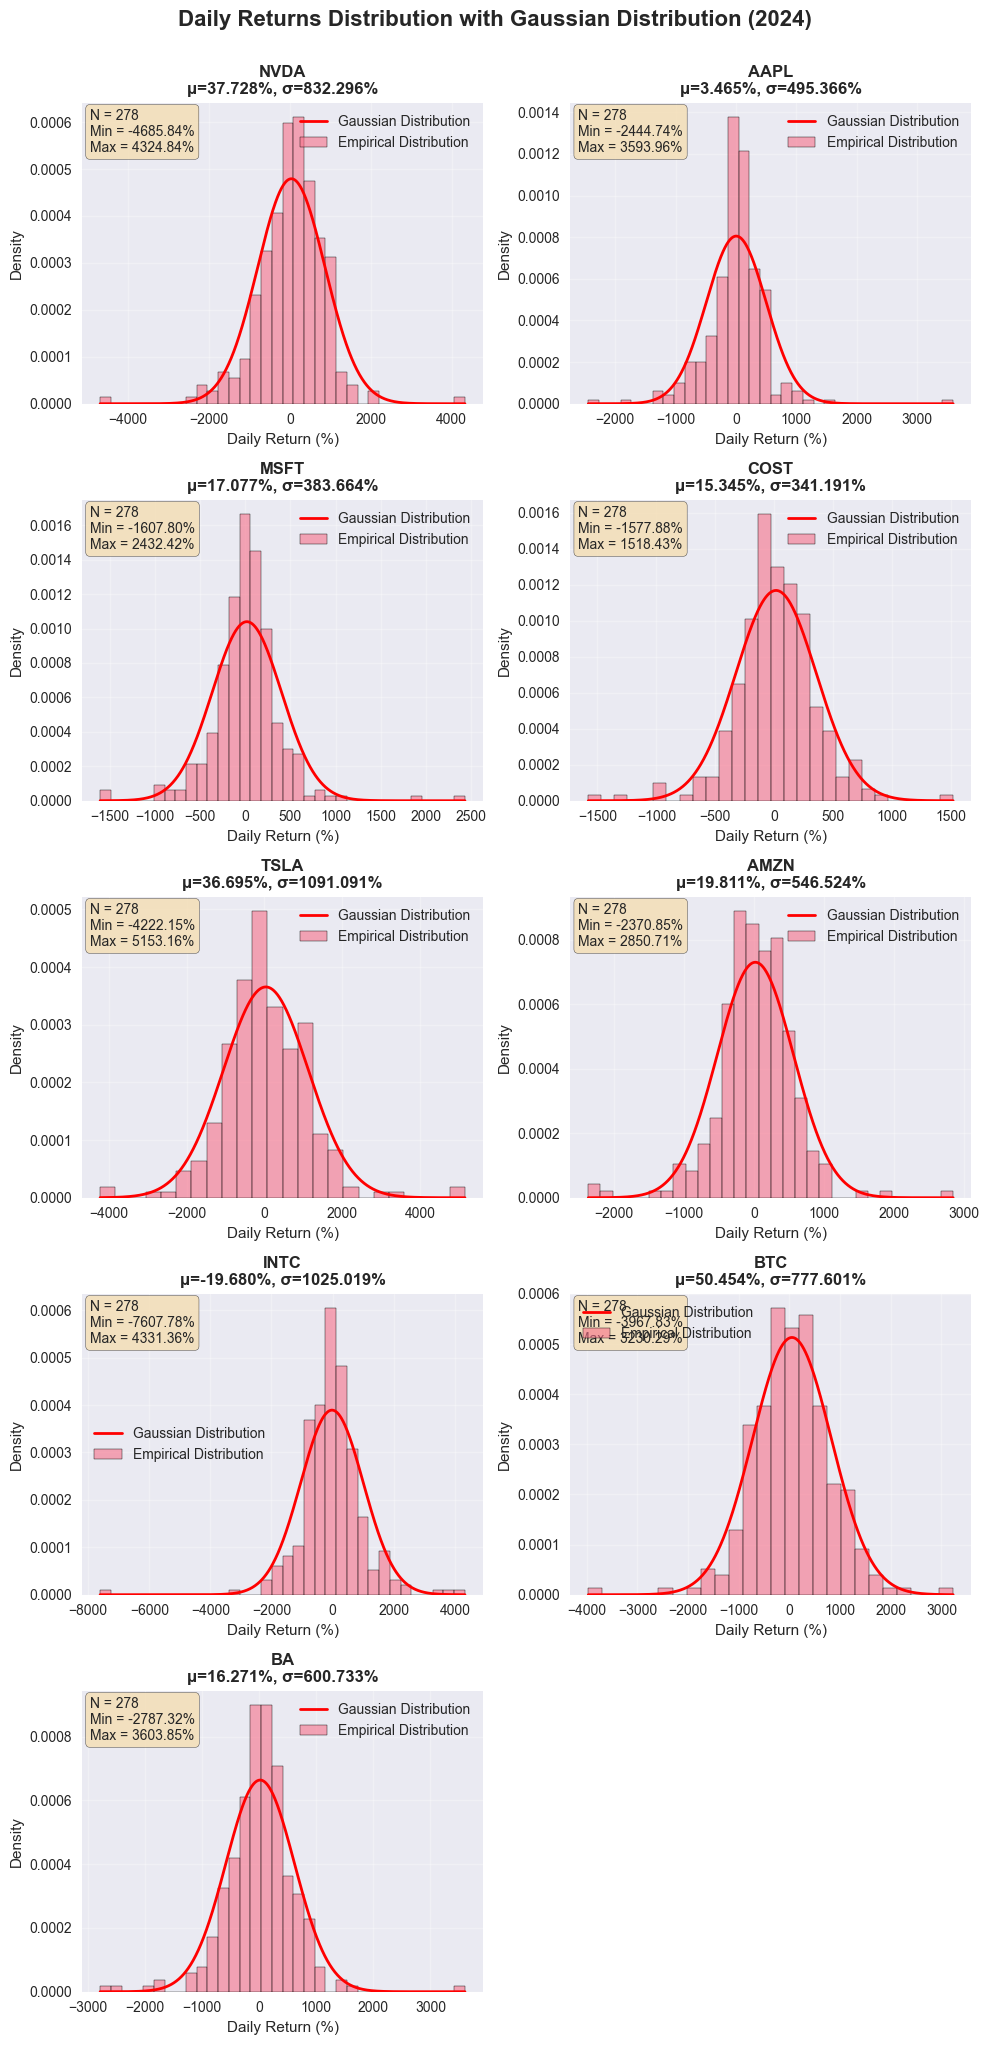

In [73]:
warnings.filterwarnings('ignore')
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Calculate the optimal grid size
n_stocks = len(stock_list)
n_cols = 2  # You can adjust this
n_rows = (n_stocks + n_cols - 1) // n_cols  # Ceiling division

# Create subplots with dynamic grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # Flatten to 1D array for easy iteration

# Plot individual stock distributions
for i, stock in enumerate(stock_list):
    returns = daily_returns[stock].dropna()
    
    # Calculate statistics
    mu = returns.mean() * 100  # Convert to percentage for display
    std = returns.std() * 100   # Convert to percentage for display
    n_observations = len(returns)
    
    # Plot histogram with KDE
    sns.histplot(returns * 100, stat='density', alpha=0.6, 
                 label='Empirical Distribution', ax=axes[i])
    
    # Generate Gaussian distribution using calculated mean and std
    x = np.linspace(returns.min() * 100, returns.max() * 100, 1000)
    gaussian = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / std) ** 2)
    
    # Plot Gaussian distribution
    axes[i].plot(x, gaussian, 'r-', linewidth=2, label='Gaussian Distribution')
    
    # Customize plot
    axes[i].set_title(f'{stock}\n'
                     f'μ={mu:.3f}%, σ={std:.3f}%',
                     fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Daily Return (%)')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Add text box with statistics
    textstr = f'N = {n_observations}\nMin = {returns.min()*100:.2f}%\nMax = {returns.max()*100:.2f}%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    axes[i].text(0.02, 0.98, textstr, transform=axes[i].transAxes, fontsize=10,
                verticalalignment='top', bbox=props)

# Remove any empty subplots
for i in range(len(stock_list), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('Daily Returns Distribution with Gaussian Distribution (2024)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

## 🧠 Machine Learning Portfolio Optimization

### Optimization Framework
We employ **advanced machine learning algorithms** to solve the portfolio optimization problem:

**Objective Function**: Maximize utility `U(w) = μᵀw - ½A·wᵀΣw`

**Constraints**:
- Budget constraint: `Σwᵢ = 1` (weights sum to 100%)
- Long-only: `wᵢ ≥ 0` (no short selling)

**Algorithms Implemented**:
1. **🎯 Adam Optimization**: Adaptive moment estimation with momentum
2. **📐 Closed-Form Solution**: Analytical solution using matrix inversion  
3. **⬇️ Gradient Descent**: Traditional first-order optimization

**Key Functions**:
- `cal_mean_var()`: Portfolio return and variance calculation
- `cal_util()`: Utility function evaluation

In [74]:
def cal_mean_var(weights, mean_np, cov_np): 
    portfolio_return = weights.T @ mean_np
    portfolio_variance = weights.T @ (cov_np @ weights)
    return portfolio_return, portfolio_variance

def cal_util(mu,var,A):
    return mu - 0.5*A*var

### 🔧 Algorithm Implementation Details

**Core Portfolio Functions**:
- **`cal_mean_var(weights, mean_np, cov_np)`**: Calculates portfolio return and variance
- **`cal_util(mu, var, A)`**: Computes utility function value

**Mathematical Foundation**:
- **Portfolio Return**: `μₚ = wᵀμ` (weighted average of expected returns)
- **Portfolio Variance**: `σ²ₚ = wᵀΣw` (quadratic form of covariance matrix)
- **Utility Function**: `U = μₚ - ½A·σ²ₚ` (return minus risk penalty)

### 🎯 Adam Optimization Algorithm

**Adam (Adaptive Moment Estimation)** is a state-of-the-art optimization algorithm that combines:
- **Momentum**: Uses exponential moving averages of gradients
- **Adaptive Learning Rates**: Adjusts step sizes per parameter
- **Bias Correction**: Corrects for initialization bias

**Key Features**:
- **β₁ = 0.9**: First moment decay rate (momentum)
- **β₂ = 0.999**: Second moment decay rate (adaptive learning)
- **ε = 1e-8**: Numerical stability constant
- **Learning Rate**: 0.0001 (conservative step size)

**Update Rule**:
```
m_t = β₁·m_{t-1} + (1-β₁)·g_t          # First moment
v_t = β₂·v_{t-1} + (1-β₂)·g_t²         # Second moment  
m̂_t = m_t / (1-β₁ᵗ)                    # Bias correction
v̂_t = v_t / (1-β₂ᵗ)                    # Bias correction
w_{t+1} = w_t - α·m̂_t / (√v̂_t + ε)    # Weight update
```

**Advantages**:
- ✅ Fast convergence
- ✅ Handles sparse gradients well
- ✅ Works well with noisy data
- ✅ Automatic learning rate adaptation

In [75]:
def ADAM(w, mean_np, cov_np, learning_rate=0.001, max_iterations=50000, beta1=0.9, beta2=0.999, epsilon=1e-8):
    util_list = np.zeros(max_iterations)  # Pre-allocate
    finish_i = max_iterations - 1  # Default if we complete all iterations
    
    # Initialize Adam parameters
    m = np.zeros_like(w)  # First moment vector
    v = np.zeros_like(w)  # Second moment vector
    t = 0  # Time step counter
    
    for i in range(max_iterations):
        t += 1
        cur_mu, cur_var = cal_mean_var(w, mean_np, cov_np)

        # Calculate gradient: A * COV @ w - MEAN
        gradient = A * (cov_np @ w) - mean_np
        
        # Update biased first moment estimate
        m = beta1 * m + (1 - beta1) * gradient
        
        # Update biased second raw moment estimate
        v = beta2 * v + (1 - beta2) * (gradient ** 2)
        
        # Compute bias-corrected first moment estimate
        m_hat = m / (1 - beta1 ** t)
        
        # Compute bias-corrected second raw moment estimate
        v_hat = v / (1 - beta2 ** t)
        
        # Update weights using Adam update rule
        w_new = w - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        
        # Project onto constraint: weights sum to 1
        w_new = w_new / np.sum(w_new)
        
        new_mu, new_var = cal_mean_var(w_new, mean_np, cov_np)
        new_util = cal_util(new_mu, new_var, A)
        
        # Store utility value
        util_list[i] = new_util
        
        # Check if converged (utility improvement is very small)
        if (new_util - cal_util(cur_mu, cur_var, A)) < 1e-9:
            finish_i = i
            break
            
        w = w_new

    # Return only the relevant portion of util_list
    return w, finish_i, util_list[:finish_i+1]

#### 📐 Closed-Form Solution

**Analytical Solution** using matrix algebra for the unconstrained optimization problem:

**Mathematical Derivation**:
1. Take gradient of utility function: `∇U = μ - A·Σw`
2. Set gradient to zero: `μ - A·Σw = 0`
3. Solve for optimal weights: `w* = (1/A)·Σ⁻¹μ`
4. Normalize to satisfy constraint: `w* = w* / Σw*`

**Implementation**:
- **Matrix Inversion**: Uses `np.linalg.inv()` or `np.linalg.pinv()` for singular matrices
- **One-Step Solution**: Computes optimal weights in a single calculation
- **Theoretical Optimum**: Provides the true mathematical optimum

**Advantages**:
- ✅ Instantaneous computation
- ✅ Guaranteed global optimum
- ✅ No convergence issues
- ✅ Exact mathematical solution

**Limitations**:
- ❌ Assumes unconstrained optimization
- ❌ May violate long-only constraints
- ❌ Requires matrix inversion (computational complexity O(n³))

In [76]:
def closed_form(A, mean_np, cov_np):
    if np.linalg.det(covariance_matrix) == 0:
        # Use pseudo-inverse if matrix is singular
        cov_inv = np.linalg.pinv(covariance_matrix)
    else:
        cov_inv = np.linalg.inv(covariance_matrix)

    w_opt = (1 / A) * cov_inv @ mean_np
    w_opt = w_opt / np.sum(w_opt)
    portfolio_return, portfolio_variance = cal_mean_var(w_opt, mean_np, cov_np)
    util = cal_util(portfolio_return,portfolio_variance,A)
    return w_opt, 1, np.array([util])

#### ⬇️ Gradient Descent Algorithm

**Classical First-Order Optimization** method using iterative gradient updates:

**Update Rule**:
```
w_{t+1} = w_t - α·∇U(w_t)
```
Where `∇U = μ - A·Σw` is the gradient of the utility function.

**Key Parameters**:
- **Learning Rate**: 0.00001 (very small for stability)
- **Max Iterations**: 1,000,000 (allows for slow convergence)
- **Convergence**: Stops when utility improvement < 1e-9

**Implementation Details**:
- **Gradient Calculation**: `A·Σw - μ` (negative of utility gradient)
- **Weight Update**: `w_new = w - α·gradient`
- **Constraint Projection**: Normalize weights to sum to 1
- **Convergence Check**: Monitor utility improvement

**Advantages**:
- ✅ Simple and intuitive
- ✅ Guaranteed convergence (with proper learning rate)
- ✅ Memory efficient
- ✅ Easy to implement

**Disadvantages**:
- ❌ Slow convergence
- ❌ Sensitive to learning rate choice
- ❌ No adaptive learning rates
- ❌ May get stuck in local minima

In [77]:
def GD(w, mean_np, cov_np, learning_rate=0.000001, max_iterations=1000000):
    util_list = np.zeros(max_iterations)  # Pre-allocate
    finish_i = max_iterations - 1  # Default if we complete all iterations
    
    for i in range(max_iterations):
        cur_mu, cur_var = cal_mean_var(w, mean_np, cov_np)

        # Calculate gradient: A * COV @ w - MEAN
        gradient = A * (cov_np @ w) - mean_np
        # Update weights
        w_new = w - learning_rate * gradient
        
        # Project onto constraint: weights sum to 1
        w_new = w_new / np.sum(w_new)
        
        new_mu, new_var = cal_mean_var(w_new, mean_np, cov_np)
        new_util = cal_util(new_mu, new_var, A)
        
        # Store utility value
        util_list[i] = new_util
        
        # Check if converged (utility decreases)
        if (new_util - cal_util(cur_mu, cur_var, A)) < 1e-9:
            finish_i = i
            break
            
        w = w_new

    # Return only the relevant portion of util_list
    return w, finish_i, util_list[:finish_i+1]

In [78]:
# Algorithm selection using switch-case structure
alg = 1  # 1 for ADAM, 2 for Closed Form, 3 for GD

initial_weights = np.array([1/len(stock_list)] * len(stock_list))

match alg:
    case 1:
        # Proper ADAM Algorithm with momentum and adaptive learning rates
        w, finish_i, util_list = ADAM(initial_weights, mean_np, cov_np, 
                                    learning_rate=0.00005, max_iterations=500000, 
                                    beta1=0.9, beta2=0.999, epsilon=1e-8)
        print("Using Adam Optimization algorithm")
        
    case 2:
        # Closed Form Algorithm
        w, finish_i, util_list = closed_form(A, mean_np, cov_np)
        print("Using Closed Form algorithm")
        
    case 3:
        # Gradient Descent Algorithm
        w, finish_i, util_list = GD(initial_weights, mean_np, cov_np, 
                                  learning_rate=0.00001, max_iterations=500000)
        print("Using Gradient Descent algorithm")
        
    case _:
        # Default case for invalid selection
        print("Invalid algorithm selection. Please choose 1, 2, or 3.")
        w, finish_i, util_list = None, None, None


Using Adam Optimization algorithm


## 📊 Optimization Results & Analysis

### Algorithm Performance Summary
This section presents the results from our portfolio optimization algorithms, including:
- **Convergence Analysis**: How quickly each algorithm reaches optimality
- **Portfolio Composition**: Final weight allocations across assets
- **Risk-Return Metrics**: Portfolio performance characteristics
- **Visual Comparisons**: Side-by-side algorithm performance

### 📈 Convergence Analysis & Portfolio Distribution

**Dual Visualization** showing:
1. **Learning Curve**: Utility progression over iterations
   - Shows convergence speed and stability
   - Indicates algorithm efficiency
   - Reveals any oscillation or instability

2. **Portfolio Return Distribution**: Gaussian fit of expected returns
   - **Mean Return**: Expected annual portfolio performance
   - **Standard Deviation**: Portfolio risk level
   - **Confidence Intervals**: ±1σ, ±2σ, ±3σ ranges
   - **Risk Assessment**: Probability of different return outcomes

**Key Insights**:
- Steep learning curves indicate fast convergence
- Smooth curves suggest stable optimization
- Portfolio distribution shows risk-return trade-off

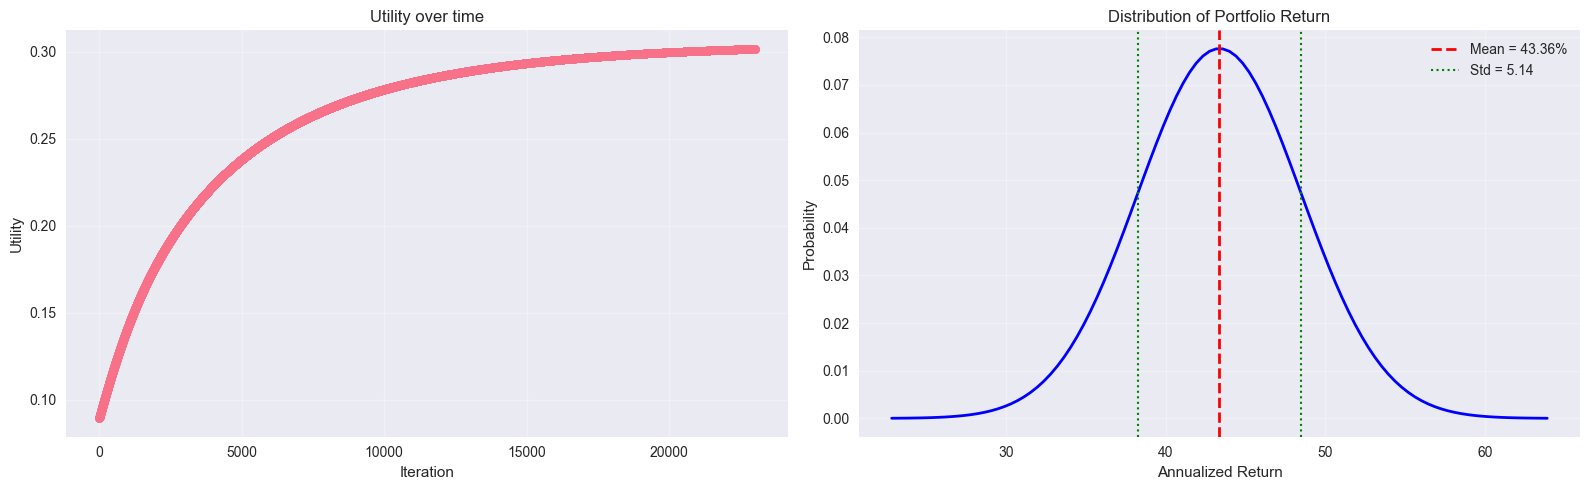

In [79]:
portfolio_return, portfolio_variance = cal_mean_var(w, mean_np, cov_np)
utility = cal_util(portfolio_return,portfolio_variance,A)
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# First plot: Utility List
ax1.plot(util_list, marker='o', linestyle='-', linewidth=2, markersize=6)
ax1.set_title('Utility over time')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Utility')
ax1.grid(True, alpha=0.3)

# Second plot: Gaussian Distribution
mean = portfolio_return*100
std = np.sqrt(portfolio_variance)
x_range = (mean - 4*std, mean + 4*std)
x = np.linspace(x_range[0], x_range[1], 100)
y = (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean)/std)**2)

ax2.plot(x, y, 'b-', linewidth=2)
ax2.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.2f}%')
ax2.axvline(mean + std, color='green', linestyle=':', linewidth=1.5, label=f'Std = {std:.2f}')
ax2.axvline(mean - std, color='green', linestyle=':', linewidth=1.5)
ax2.set_title(f'Distribution of Portfolio Return')
ax2.set_xlabel('Annualized Return')
ax2.set_ylabel('Probability')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

### 📋 Portfolio Summary & Allocation Analysis

**Comprehensive Portfolio Report** including:

**Portfolio Statistics**:
- **Position Count**: Number of long vs short positions
- **Allocation Range**: Maximum and minimum weight allocations
- **Utility Score**: Final optimized utility value
- **Learning Rate**: Step size used in optimization

**Detailed Breakdown**:
- **Asset-by-Asset Allocation**: Individual weight percentages
- **Position Types**: Long (positive) vs Short (negative) positions
- **Weight Ranking**: Assets sorted by allocation magnitude

**Visual Analysis**:
- **Horizontal Bar Chart**: Visual representation of allocations
- **Color Coding**: Green for long positions, red for short positions
- **Value Labels**: Precise percentage allocations on each bar

**Key Metrics**:
- **Diversification**: How spread out the allocations are
- **Concentration Risk**: Whether portfolio is concentrated in few assets
- **Risk Profile**: Overall portfolio risk characteristics

PORTFOLIO ANALYSIS
# of Long Positions:             7
# of Short Positions:            2
Max Allocation:              24.0%
Min Allocation:             -23.2%
Utility:                      0.30

DETAILED BREAKDOWN:
--------------------------------------------------
  AAPL:    24.0% (LONG)
  INTC:    23.5% (LONG)
  TSLA:    23.5% (LONG)
  COST:    23.5% (LONG)
   BTC:    23.5% (LONG)
  NVDA:   -23.2% (SHORT)
  AMZN:   -23.0% (SHORT)
  MSFT:    18.6% (LONG)
    BA:     9.6% (LONG)


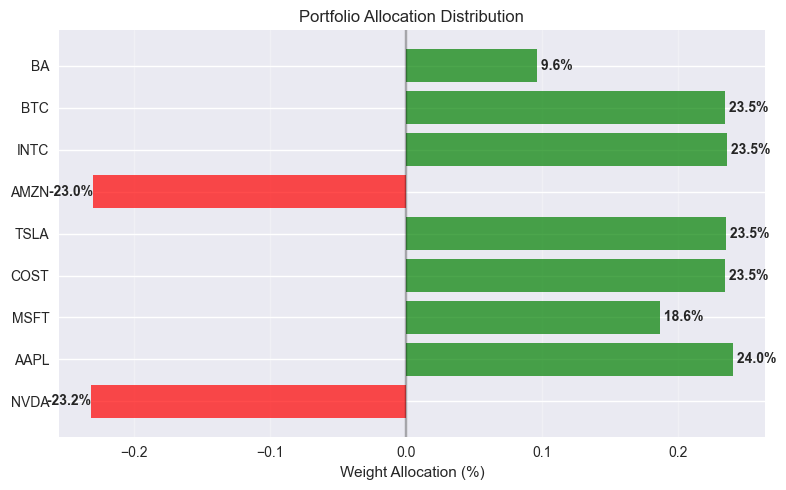

In [80]:
# Sample data (replace with your actual data)
positive_weights = [w for w in w if w > 0]
negative_weights = [w for w in w if w < 0]

print("PORTFOLIO ANALYSIS")
print("=" * 50)
print(f"{'# of Long Positions:':<25} {len(positive_weights):>8}")
print(f"{'# of Short Positions:':<25} {len(negative_weights):>8}")
print(f"{'Max Allocation:':<25} {max(w):>8.1%}")
print(f"{'Min Allocation:':<25} {min(w):>8.1%}")
print(f"{'Utility:':<25} {utility:>8.2f}")
print("\nDETAILED BREAKDOWN:")
print("-" * 50)

# Sort by absolute weight (descending)
sorted_data = sorted(zip(stock_list, w), key=lambda x: abs(x[1]), reverse=True)

for stock, weight in sorted_data:
    position_type = "LONG" if weight > 0 else "SHORT"
    print(f"{stock:>6}: {weight:>8.1%} ({position_type})")

# Create bar graph
plt.figure(figsize=(8, 5))
colors = ['green' if weight > 0 else 'red' for weight in w]
bars = plt.barh(stock_list, w, color=colors, alpha=0.7)

plt.xlabel('Weight Allocation (%)')
plt.title('Portfolio Allocation Distribution')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='x', alpha=0.3)

# Add value labels to bars
for i, (stock, weight) in enumerate(zip(stock_list, w)):
    plt.text(weight, i, f' {weight:.1%}', 
             va='center', 
             ha='left' if weight > 0 else 'right',
             fontweight='bold')

plt.tight_layout()
plt.show()

### 🎮 Interactive Portfolio Distribution Explorer

**Advanced Interactive GUI** built with PyQt5 for real-time portfolio analysis:

**Features**:
- **📊 Real-time Distribution Plot**: Gaussian distribution of portfolio returns
- **🎚️ Interactive Slider**: Adjust return thresholds dynamically
- **📈 Probability Calculator**: Live calculation of return probabilities
- **🎯 Visual Indicators**: Mean, standard deviation, and selected return lines

**Interactive Elements**:
- **Return Slider**: Drag to select different return values
- **Probability Display**: Shows probability of earning more than selected return
- **Dynamic Annotation**: Updates with current return and probability values
- **Statistical Overlay**: Mean and standard deviation reference lines

**Use Cases**:
- **Risk Assessment**: "What's the probability of losing more than 10%?"
- **Return Expectations**: "What's the chance of earning more than 15%?"
- **Confidence Intervals**: Visualize different confidence levels
- **Scenario Analysis**: Explore various return scenarios

**Technical Implementation**:
- **PyQt5 Framework**: Professional desktop application
- **Matplotlib Integration**: High-quality statistical plots
- **Real-time Updates**: Instant probability calculations
- **Responsive Design**: Smooth slider interactions

In [81]:
class GaussianPlotter(QMainWindow):
    def __init__(self, portfolio_return, portfolio_variance):
        super().__init__()
        self.mean = portfolio_return
        self.variance = portfolio_variance
        self.std_dev = np.sqrt(self.variance)
        self.app = None  # Store app reference for cleanup
        self.initUI()
        
    def initUI(self):
        self.setWindowTitle(f"Interactive Gaussian Distribution: N({self.mean:.2f},{self.variance:.2f})")
        self.setGeometry(100, 100, 1200, 800)
        
        # Main widget and layout
        central_widget = QWidget()
        self.setCentralWidget(central_widget)
        main_layout = QHBoxLayout(central_widget)
        
        # Left panel for controls
        control_panel = QGroupBox("Controls")
        control_layout = QVBoxLayout()
        
        # Return selection with slider
        return_layout = QVBoxLayout()
        return_layout.addWidget(QLabel("Select Return (%):"))
        
        # Slider for return selection
        self.return_slider = QSlider(Qt.Horizontal)
        self.return_slider.setMinimum(0)
        self.return_slider.setMaximum(1000)  # Use fine granularity for smooth sliding
        return_layout.addWidget(self.return_slider)
        
        # Display for current return value
        self.return_display = QLabel(f"{self.mean:.2f}%")
        self.return_display.setStyleSheet("font-weight: bold; font-size: 20px;")
        self.return_display.setAlignment(Qt.AlignCenter)
        return_layout.addWidget(self.return_display)
        
        control_layout.addLayout(return_layout)
        
        # Probability display
        self.prob_label = QLabel("")
        self.prob_label.setStyleSheet("font-weight: bold; font-size: 24px;")
        control_layout.addWidget(self.prob_label)
        
        # Additional info
        info_label = QLabel("Drag the slider to select different return values and see the corresponding probabilities")
        info_label.setWordWrap(True)
        control_layout.addWidget(info_label)
        
        control_panel.setLayout(control_layout)
        control_panel.setFixedWidth(300)
        main_layout.addWidget(control_panel)
        
        # Right panel for plot
        plot_widget = QWidget()
        plot_layout = QVBoxLayout(plot_widget)
        
        # Matplotlib figure
        self.figure = Figure(figsize=(10, 8))
        self.canvas = FigureCanvas(self.figure)
        plot_layout.addWidget(self.canvas)
        
        main_layout.addWidget(plot_widget)
        
        # Initialize plot first to create the selected_line attribute
        self.setup_plot()
        
        # Then initialize slider and connect the signal
        self.initialize_slider()
        self.return_slider.valueChanged.connect(self.slider_changed)
        
    def initialize_slider(self):
        """Initialize the slider range based on the distribution parameters"""
        min_val = self.mean - 4 * self.std_dev
        max_val = self.mean + 4 * self.std_dev
        
        # Set slider range (we'll map the 0-1000 slider values to the actual range)
        self.slider_min = min_val
        self.slider_max = max_val
        
        # Set initial slider position to correspond to the mean
        initial_slider_value = int(500)  # Middle of the range (0-1000)
        self.return_slider.setValue(initial_slider_value)
        
    def slider_changed(self, value):
        """Handle slider value changes"""
        # Convert slider value (0-1000) to actual return value
        return_value = self.slider_min + (value / 1000) * (self.slider_max - self.slider_min)
        
        # Update display
        self.return_display.setText(f"{return_value:.2f}%")
        
        # Update plot
        self.update_plot(return_value)
        
    def setup_plot(self):
        self.figure.clear()
        self.ax = self.figure.add_subplot(111)
        
        # Calculate x range
        x_range = (self.mean - 4*self.std_dev, self.mean + 4*self.std_dev)
        x = np.linspace(x_range[0], x_range[1], 1000)
        y = norm.pdf(x, self.mean, self.std_dev)
        
        # Plot Gaussian curve
        self.ax.plot(x, y, 'b-', linewidth=2, label=f'N({self.mean:.2f}, {self.variance:.4f})')
        
        # Plot mean line
        self.ax.axvline(self.mean, color='red', linestyle='--', linewidth=2, 
                       label=f'Mean (μ) = {self.mean:.2f}%')
        
        # Plot ±1 standard deviation lines
        self.ax.axvline(self.mean + self.std_dev, color='green', linestyle=':', linewidth=2,
                       label=f'Std Dev (σ) = {self.std_dev:.4f}')
        self.ax.axvline(self.mean - self.std_dev, color='green', linestyle=':', linewidth=2)
        
        # Plot selected return line
        self.selected_line = self.ax.axvline(self.mean, color='purple', linestyle='-', 
                                           linewidth=3, alpha=0.8)
        
        # Add annotation
        self.annotation = self.ax.annotate(
            '',
            xy=(self.mean, norm.pdf(self.mean, self.mean, self.std_dev)),
            xytext=(20, 40),
            textcoords='offset points',
            bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="black", alpha=0.9),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", color='black')
        )
        
        # Set labels and title
        self.ax.set_title('Interactive Portfolio Return Distribution', 
                         fontsize=20)
        self.ax.set_xlabel('Return (%)', fontsize=18)
        self.ax.set_ylabel('Probability Density', fontsize=18)
        
        # Add legend and grid
        self.ax.legend()
        self.ax.grid(True, alpha=0.3)
        
        # Update plot with initial values
        self.update_plot(self.mean)
        
    def update_plot(self, selected_return):
        # Update vertical line position
        self.selected_line.set_xdata([selected_return, selected_return])
        
        # Calculate probabilities
        prob_greater = 1 - norm.cdf(selected_return, self.mean, self.std_dev)
        prob_less = norm.cdf(selected_return, self.mean, self.std_dev)
        pdf_value = norm.pdf(selected_return, self.mean, self.std_dev)
        
        # Update annotation text and position
        annotation_text = (f'Return: {selected_return:.2f}%\n'
                          f'P(return > {selected_return:.2f}%) = {prob_greater:.4f}\n'
                          f'P(return < {selected_return:.2f}%) = {prob_less:.4f}')
        
        self.annotation.set_text(annotation_text)
        self.annotation.xy = (selected_return, pdf_value)
        
        # Update probability label
        self.prob_label.setText(f"\nYou have {prob_greater*100:.1f}% \nprobability to earn \nmore than {selected_return:.2f}%")
        # Redraw canvas
        self.canvas.draw()
        
    def closeEvent(self, event):
        """Handle window close event with proper cleanup"""
        try:
            # Clean up matplotlib resources
            if hasattr(self, 'figure'):
                self.figure.clear()
            if hasattr(self, 'canvas'):
                self.canvas.close()
            
            # Close the window properly
            event.accept()
            print("GUI application closed successfully.")
        except Exception as e:
            print(f"Error during cleanup: {e}")
            event.accept()  # Still accept the close event

def run_interactive_gui():
    """Run the interactive GUI with proper error handling and cleanup"""
    app = None
    window = None
    
    try:
        # Check if QApplication already exists (common in Jupyter)
        app = QApplication.instance()
        if app is None:
            app = QApplication(sys.argv)
        else:
            print("Using existing QApplication instance")
        
        # Create and show window
        window = GaussianPlotter(portfolio_return*100, portfolio_variance)
        window.app = app  # Store app reference
        window.show()
        
        print("Interactive GUI started. Close the window to exit.")
        
        # Process events in a way that's compatible with Jupyter
        if hasattr(app, 'processEvents'):
            # For Jupyter compatibility, we'll use a timer-based approach
            from PyQt5.QtCore import QTimer
            timer = QTimer()
            timer.timeout.connect(app.processEvents)
            timer.start(100)  # Process events every 100ms
            
            # Keep the window alive until it's closed
            while window.isVisible():
                app.processEvents()
                import time
                time.sleep(0.01)  # Small delay to prevent excessive CPU usage
                
        else:
            # Fallback to exec_ if processEvents is not available
            app.exec_()
            
    except Exception as e:
        print(f"Error running GUI: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # Cleanup
        if window and hasattr(window, 'close'):
            window.close()
        if app and hasattr(app, 'quit'):
            app.quit()
        print("GUI cleanup completed.")

# Run the interactive GUI
run_interactive_gui()

Using existing QApplication instance
Interactive GUI started. Close the window to exit.
GUI application closed successfully.
GUI application closed successfully.
GUI cleanup completed.
